В данном проекте нам предстоит разработать модели машинного обучения для прогнозирования удоя коров и вероятности получения вкусного молока, чтобы помочь фермеру отобрать бурёнок с высоким качеством молока и удоя для расширения стада.

**Цель исследования:** создать две прогнозные модели для оценки удоя коров и вероятности получения вкусного молока, чтобы обеспечить отбор коров, соответствующих требованиям фермера.

**Задачи исследования:** 

1. Создать две прогнозные модели для отбора бурёнок в поголовье:
- Первая будет прогнозировать возможный удой коровы (целевой признак Удой);
- Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак Вкус молока). 

2. С помощью модели нужно отобрать коров по двум критериям:
- средний удой за год — не менее 6000 килограммов;
- молоко должно быть вкусным.

**Ход исследования:**

**Описание данных:** 

1. ***ferma_main.csv*** содержит данные о стаде фермера на текущий момент. 
- id — уникальный идентификатор коровы. 
- Удой, кг — масса молока, которую корова даёт в год (в килограммах). 
- ЭКЕ (Энергетическая кормовая единица) — показатель питательности корма коровы. 
- Сырой протеин, г — содержание сырого протеина в корме (в граммах). 
- СПО (Сахаро-протеиновое соотношение) — отношение сахара к протеину в корме коровы. 
- Порода — порода коровы. 
- Тип пастбища — ландшафт лугов, на которых паслась корова. 
- порода папы_быка — порода папы коровы. 
- Жирность,% — содержание жиров в молоке (в процентах). 
- Белок,% — содержание белков в молоке (в процентах). 
- Вкус молока — оценка вкуса по личным критериям фермера, бинарный признак (вкусно, не вкусно). 
- Возраст — возраст коровы, бинарный признак (менее_2_лет, более_2_лет). 

2. ***ferma_dad.csv*** хранит имя папы каждой коровы в стаде фермера. 
- id — уникальный идентификатор коровы.
- Имя Папы — имя папы коровы.

3. ***cow_buy.csv*** — это данные о коровах «ЭкоФермы», которые фермер хочет изучить перед покупкой. 
- Порода — порода коровы.
- Тип пастбища — ландшафт лугов, на которых паслась корова.
- порода папы_быка — порода папы коровы.
- Имя_папы — имя папы коровы.
- Текущая_жирность,% — содержание жиров в молоке (в процентах).
- Текущий_уровень_белок,% — содержание белков в молоке (в процентах).
- Возраст — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).

# Загрузка данных

In [164]:
# импорт используемых библиотек

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (
    r2_score,
    mean_absolute_error, 
    mean_squared_error, 
    accuracy_score, 
    precision_score,
    recall_score, 
    precision_recall_curve, 
    confusion_matrix
)
import scipy.stats as stats
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve
from sklearn.calibration import calibration_curve

In [165]:
# загрузка даатсетов

ferma_main = pd.read_csv('https://code.s3.yandex.net/datasets/ferma_main.csv', delimiter=';')
ferma_dad = pd.read_csv('https://code.s3.yandex.net/datasets/ferma_dad.csv', delimiter=';')
cow_buy = pd.read_csv('https://code.s3.yandex.net/datasets/cow_buy.csv', delimiter=';')

In [166]:
# функция для получения базовой информации о датасетах

def get_info(df):
    print("Размер датасета:", df.shape, sep='\n', end='\n\n')
    display(df)
    print('\n')
    display(df.info())
    print('\n')
    display(df.describe().T)
    print("Количество пропусков:", df.isna().sum(), sep='\n', end='\n\n')
    print("Количество явных дубликатов:", df.duplicated().sum(), end='\n\n')
    display(df[df.duplicated() == True])

In [167]:
get_info(ferma_main)

Размер датасета:
(634, 12)



,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,"14,2",1743,"0,89",Вис Бик Айдиал,Равнинное,Айдиал,"3,58","3,076",вкусно,более_2_лет
1,2,5529,"12,8",2138,"0,89",Вис Бик Айдиал,Равнинные,Соверин,"3,54","3,079",вкусно,менее_2_лет
2,3,5810,14,1854,"0,885",РефлешнСоверинг,Холмистое,Соверин,"3,59","3,074",не вкусно,более_2_лет
3,4,5895,"12,4",2012,"0,885",РефлешнСоверинг,Холмистое,Айдиал,"3,4","3,075",не вкусно,более_2_лет
4,5,5302,"12,8",1675,"0,885",Вис Бик Айдиал,Равнинные,Соверин,"3,73","3,073",вкусно,менее_2_лет
...,...,...,...,...,...,...,...,...,...,...,...,...
629,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
630,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
631,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
632,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   id                                     634 non-null    int64 
 1   Удой, кг                               634 non-null    int64 
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    object
 3   Сырой протеин, г                       634 non-null    int64 
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    object
 5   Порода                                 634 non-null    object
 6   Тип пастбища                           634 non-null    object
 7   порода папы_быка                       634 non-null    object
 8   Жирность,%                             634 non-null    object
 9   Белок,%                                634 non-null    object
 10  Вкус молока                            634 non-null    object
 11  Возраст          

None

,count,mean,std,min,25%,50%,75%,max
id,634.0,317.460568,183.096982,1.0,159.25,317.5,475.75,629.0
"Удой, кг",634.0,6187.025237,1638.401021,5204.0,5751.75,6130.5,6501.00,45616.0
"Сырой протеин, г",634.0,1922.682965,182.392548,1660.0,1772.25,1880.5,2058.75,2349.0


Количество пропусков:
id                                       0
Удой, кг                                 0
ЭКЕ (Энергетическая кормовая единица)    0
Сырой протеин, г                         0
СПО (Сахаро-протеиновое соотношение)     0
Порода                                   0
Тип пастбища                             0
порода папы_быка                         0
Жирность,%                               0
Белок,%                                  0
Вкус молока                              0
Возраст                                  0
dtype: int64

Количество явных дубликатов: 5



,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
629,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
630,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
631,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
632,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
633,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет


Пропуски отсутствуют, но есть 5 явных дубликатов. Удалим их. 

*P.S. Проверку на неявные дубликаты выполним в блоке с предобработкой, когда приведем данные к единому виду.*

In [168]:
ferma_main.drop_duplicates(inplace=True)
print(f'Количество дубликатов: {ferma_main.duplicated().sum()}')
ferma_main

Количество дубликатов: 0


,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,"14,2",1743,"0,89",Вис Бик Айдиал,Равнинное,Айдиал,"3,58","3,076",вкусно,более_2_лет
1,2,5529,"12,8",2138,"0,89",Вис Бик Айдиал,Равнинные,Соверин,"3,54","3,079",вкусно,менее_2_лет
2,3,5810,14,1854,"0,885",РефлешнСоверинг,Холмистое,Соверин,"3,59","3,074",не вкусно,более_2_лет
3,4,5895,"12,4",2012,"0,885",РефлешнСоверинг,Холмистое,Айдиал,"3,4","3,075",не вкусно,более_2_лет
4,5,5302,"12,8",1675,"0,885",Вис Бик Айдиал,Равнинные,Соверин,"3,73","3,073",вкусно,менее_2_лет
...,...,...,...,...,...,...,...,...,...,...,...,...
624,625,6812,"15,4",1964,"0,94",РефлешнСоверинг,Равнинное,Айдиал,"3,74","3,075",не вкусно,более_2_лет
625,626,5513,"12,9",1700,"0,88",РефлешнСоверинг,Равнинное,Соверин,"3,64","3,073",вкусно,менее_2_лет
626,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
627,628,5746,"13,8",1994,"0,89",РефлешнСоверинг,Равнинное,Соверин,"3,64","3,077",вкусно,более_2_лет


In [169]:
get_info(ferma_dad)

Размер датасета:
(629, 2)



,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин
...,...,...
624,625,Буйный
625,626,Барин
626,627,Барин
627,628,Барин




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


None

,count,mean,std,min,25%,50%,75%,max
id,629.0,315.0,181.72094,1.0,158.0,315.0,472.0,629.0


Количество пропусков:
id          0
Имя Папы    0
dtype: int64

Количество явных дубликатов: 0



,id,Имя Папы


Пропуски и явные дубликаты в ferma_dad отсутствуют. Более того, количество строк совпадает с ferma_main. 

In [170]:
get_info(cow_buy)

Размер датасета:
(20, 7)



,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,54","3,081",менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,061",более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,"3,63","3,053",менее_2_лет
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,57","3,079",более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,079",менее_2_лет




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Порода                   20 non-null     object
 1   Тип пастбища             20 non-null     object
 2   порода папы_быка         20 non-null     object
 3   Имя_папы                 20 non-null     object
 4   Текущая_жирность,%       20 non-null     object
 5   Текущий_уровень_белок,%  20 non-null     object
 6   Возраст                  20 non-null     object
dtypes: object(7)
memory usage: 1.2+ KB


None

,count,unique,top,freq
Порода,20,2,РефлешнСоверинг,11
Тип пастбища,20,2,равнинное,11
порода папы_быка,20,2,Соверин,12
Имя_папы,20,4,Буйный,8
"Текущая_жирность,%",20,12,"3,4",3
"Текущий_уровень_белок,%",20,12,"3,074",5
Возраст,20,2,более_2_лет,15


Количество пропусков:
Порода                     0
Тип пастбища               0
порода папы_быка           0
Имя_папы                   0
Текущая_жирность,%         0
Текущий_уровень_белок,%    0
Возраст                    0
dtype: int64

Количество явных дубликатов: 4



,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
14,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
19,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет


Пропусков нет, проблема с индексами отсутствует. Однако нашлось 4 явных дубликата, исправим это. 

In [171]:
#cow_buy.drop_duplicates(inplace=True)
#print(f'Количество дубликатов: {cow_buy.duplicated().sum()}')

### Вывод

1. **ferma_main**: 
- Пропусков не найдено 
- Удалили 5 явных дубликатов 
- Исправить типы данных в столбцах, требующих этого (ЭКЕ, СПО, Жирность, Белок)

2. **ferma_dad**: 
- Пропусков и явных дубликатов не найдено 
- Типы данных соответствуют действительности 

3. **cow_buy**: 
- Пропусков не найдено 
- Удалили 4 явных дубликата 
- Исправить типы данных в столбцах, требующих этого (Текущая_жирность, Текущий_уровень_белок,%)
- Проблем с индексами не найдено 

#  Предобработка данных

### Приведем названия столбцов к общему виду

In [172]:
ferma_main.rename(columns={
    'Удой, кг': 'удой',
    'ЭКЕ (Энергетическая кормовая единица)': 'эке',
    'Сырой протеин, г': 'сырой_протеин',
    'СПО (Сахаро-протеиновое соотношение)': 'спо',
    'Порода': 'порода',
    'Тип пастбища': 'тип_пастбища',
    'порода папы_быка': 'порода_папы_быка',
    'Жирность,%': 'жирность',
    'Белок,%': 'белок',
    'Вкус молока': 'вкус_молока',
    'Возраст': 'возраст',
}, inplace=True)

ferma_main.head(5)

,id,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст
0,1,5863,"14,2",1743,"0,89",Вис Бик Айдиал,Равнинное,Айдиал,"3,58","3,076",вкусно,более_2_лет
1,2,5529,"12,8",2138,"0,89",Вис Бик Айдиал,Равнинные,Соверин,"3,54","3,079",вкусно,менее_2_лет
2,3,5810,14,1854,"0,885",РефлешнСоверинг,Холмистое,Соверин,"3,59","3,074",не вкусно,более_2_лет
3,4,5895,"12,4",2012,"0,885",РефлешнСоверинг,Холмистое,Айдиал,"3,4","3,075",не вкусно,более_2_лет
4,5,5302,"12,8",1675,"0,885",Вис Бик Айдиал,Равнинные,Соверин,"3,73","3,073",вкусно,менее_2_лет


In [173]:
ferma_dad.rename(columns={'Имя Папы': 'имя_папы_быка'}, inplace=True)
ferma_dad.head(5)

,id,имя_папы_быка
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


In [174]:
cow_buy.rename(columns={
    'Порода': 'порода',
    'Тип пастбища': 'тип_пастбища',
    'порода папы_быка': 'порода_папы_быка',
    'Имя_папы': 'имя_папы_быка',
    'Текущая_жирность,%': 'текущая_жирность',
    'Текущий_уровень_белок,%': 'текущий_белок',
    'Возраст': 'возраст',
}, inplace=True)

cow_buy.head(5)

,порода,тип_пастбища,порода_папы_быка,имя_папы_быка,текущая_жирность,текущий_белок,возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,54","3,081",менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,061",более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет


### Приведем типы данных столбцов

Исправим типы данных в столбцах, требующих этого: ЭКЕ, СПО, Жирность, Белок в ferma_main и Текущая_жирность, Текущий_уровень_белок,% в cow_buy.

In [175]:
ferma_main['эке'] = ferma_main['эке'].str.replace(',', '.').astype('float64')
print(ferma_main['эке'].dtype)

ferma_main['спо'] = ferma_main['спо'].str.replace(',', '.').astype('float64')
print(ferma_main['спо'].dtype)

ferma_main['жирность'] = ferma_main['жирность'].str.replace(',', '.').astype('float64')
print(ferma_main['жирность'].dtype)

ferma_main['белок'] = ferma_main['белок'].str.replace(',', '.').astype('float64')
print(ferma_main['белок'].dtype)

float64
float64
float64
float64


In [176]:
cow_buy['текущая_жирность'] = cow_buy['текущая_жирность'].str.replace(',', '.').astype('float64')
print(cow_buy['текущая_жирность'].dtype)

cow_buy['текущий_белок'] = cow_buy['текущий_белок'].str.replace(',', '.').astype('float64')
print(cow_buy['текущий_белок'].dtype)

float64
float64


### Поиск неявных дубликатов

В **ferma_main** найдены неявные дубликаты: 'Равнинное', 'Равнинные' в 'тип_пастбища' и 'Айдиал', 'Айдиалл' в 'порода_папы_быка':

In [177]:
unique_main = {}
for column in ferma_main.columns:
    if ferma_main[column].dtype == 'object':
        unique_main[column] = ferma_main[column].unique()

print(unique_main)

{'порода': array(['Вис Бик Айдиал', 'РефлешнСоверинг'], dtype=object), 'тип_пастбища': array(['Равнинное', 'Равнинные', 'Холмистое'], dtype=object), 'порода_папы_быка': array(['Айдиал', 'Соверин', 'Айдиалл'], dtype=object), 'вкус_молока': array(['вкусно', 'не вкусно'], dtype=object), 'возраст': array(['более_2_лет', 'менее_2_лет'], dtype=object)}


In [178]:
ferma_main['тип_пастбища'].replace({'Равнинные': 'Равнинное'}, inplace=True)
ferma_main['порода_папы_быка'].replace({'Айдиалл': 'Айдиал'}, inplace=True)

display(ferma_main['тип_пастбища'].unique(), ferma_main['порода_папы_быка'].unique())

array(['Равнинное', 'Холмистое'], dtype=object)

array(['Айдиал', 'Соверин'], dtype=object)

В **ferma_dad** неявные дубликаты не найдены. 

In [179]:
unique_dad = {}
for column in ferma_dad.columns:
    if ferma_dad[column].dtype == 'object':
        unique_dad[column] = ferma_dad[column].unique()

print(unique_dad)

{'имя_папы_быка': array(['Буйный', 'Соловчик', 'Барин', 'Геркулес'], dtype=object)}


В **cow_buy** неявные дубликаты также отсутствуют. Однако типы пастбища написаны с маленькой буквы ('тип_пастбища': array(['холмистое', 'равнинное']), предлагаю в ferma_main перевести типы пастбища в тот же регистр, чтобы данные совпадали. 

In [180]:
unique_buy = {}
for column in cow_buy.columns:
    if cow_buy[column].dtype == 'object':
        unique_buy[column] = cow_buy[column].unique()

print(unique_buy)

{'порода': array(['Вис Бик Айдиал', 'РефлешнСоверинг'], dtype=object), 'тип_пастбища': array(['холмистое', 'равнинное'], dtype=object), 'порода_папы_быка': array(['Айдиал', 'Соверин'], dtype=object), 'имя_папы_быка': array(['Геркулес', 'Буйный', 'Барин', 'Соловчик'], dtype=object), 'возраст': array(['более_2_лет', 'менее_2_лет'], dtype=object)}


In [181]:
ferma_main['тип_пастбища'].replace({'Холмистое':'холмистое', 'Равнинное':'равнинное'}, inplace=True)

### Вывод

- Названия столбцов приведены к общему виду нижнего регистра.
- Типы данных в датасетах ferma_main и cow_buy были изменены на корректные.
- Удалены неявные дубликатыв датасете ferma_main, в двух других они не были найдены.

# Исследовательский анализ данных

Исследовательский анализ будем выполнять в два этапа: сначала исследование количественных признаков, затем категориальных.

## Количественные признаки

### удой

In [182]:
ferma_main['удой'].describe()

count      629.000000
mean      6188.750397
std       1644.795489
min       5204.000000
25%       5751.000000
50%       6133.000000
75%       6501.000000
max      45616.000000
Name: удой, dtype: float64

Сразу бросается в глаза нереалистичный максимум - 45616 кг молока в год. Отсортируем столбец по убыванию и построем графики.

In [183]:
ferma_main['удой'].sort_values(ascending=False)

16     45616
70      7222
135     7207
296     7201
294     7197
       ...  
578     5235
322     5215
589     5213
397     5207
273     5204
Name: удой, Length: 629, dtype: int64

Перед нами типичный выброс, его можно удалить. 

In [184]:
ferma_main.drop(ferma_main['удой'].idxmax(), inplace=True)

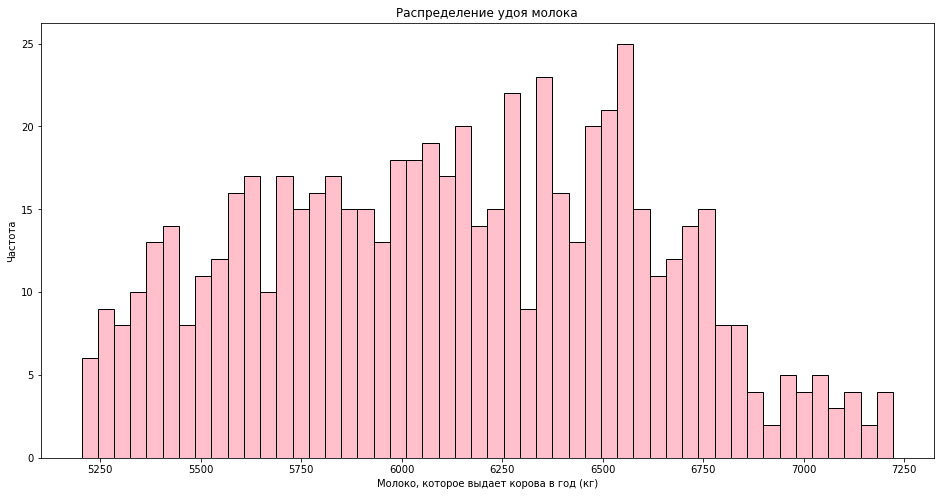

In [185]:
plt.figure(figsize=(16, 8))
plt.hist(ferma_main['удой'], color='pink', edgecolor='black', bins=50)
plt.title('Распределение удоя молока')
plt.xlabel('Молоко, которое выдает корова в год (кг)')
plt.ylabel('Частота')
plt.show()

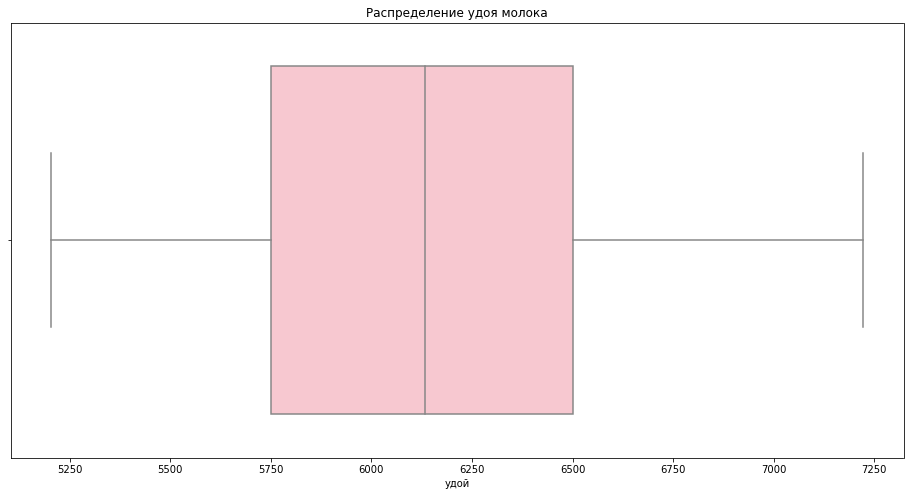

In [186]:
plt.figure(figsize=(16, 8))
sns.boxplot(x=ferma_main['удой'], color='pink')
plt.title('Распределение удоя молока')
plt.show()

Видна большая концентрация значений удоя в диапазоне от 5750 до 6500 кг. Медиана - 6132 кг. Данные кажутся неравномерно распределёнными с локальными пиками, но общая картина данных выглядит достаточно правдоподобно.

### эке

In [187]:
ferma_main['эке'].describe()

count    628.000000
mean      14.548726
std        1.301777
min       10.900000
25%       13.500000
50%       14.700000
75%       15.600000
max       16.800000
Name: эке, dtype: float64

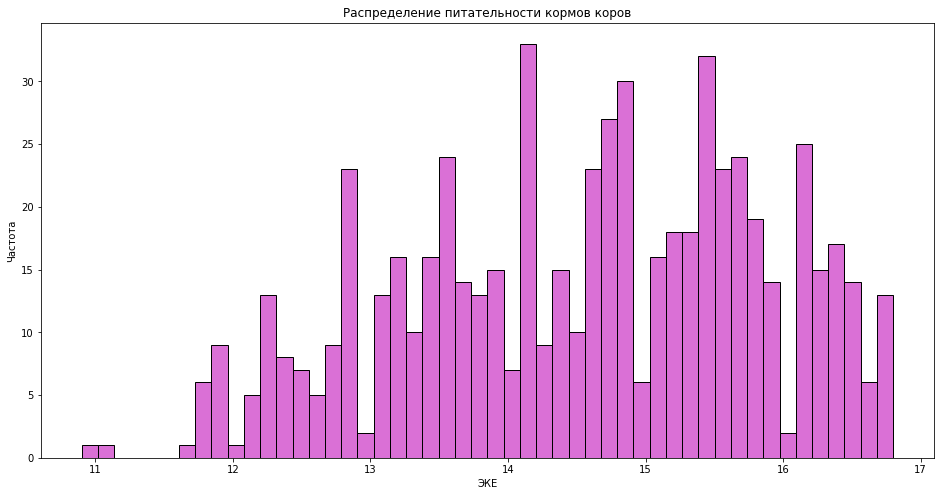

In [188]:
plt.figure(figsize=(16, 8))
plt.hist(ferma_main['эке'], color='orchid', edgecolor='black', bins=50)
plt.title('Распределение питательности кормов коров')
plt.xlabel('ЭКЕ')
plt.ylabel('Частота')
plt.show()

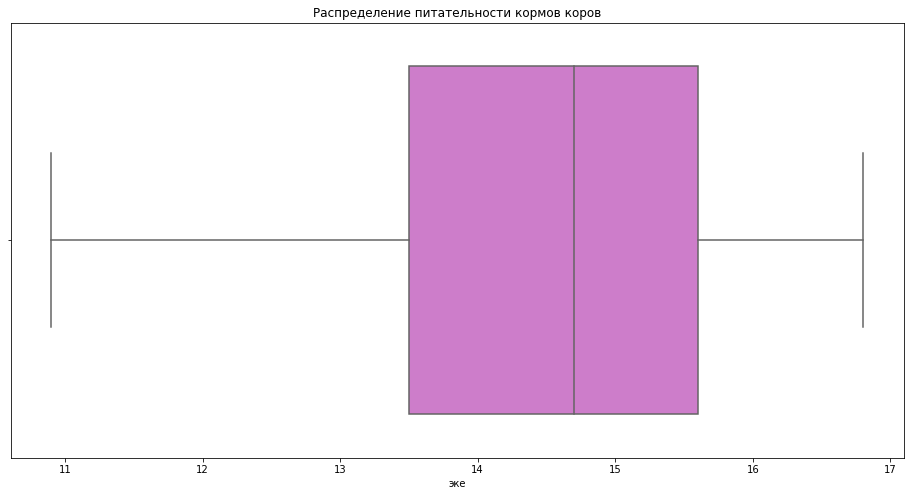

In [189]:
plt.figure(figsize=(16, 8))
sns.boxplot(x=ferma_main['эке'], color='orchid')
plt.title('Распределение питательности кормов коров')
plt.show()

Распределение не очень равномерно, имеет свои пики. Эти пики могут быть связаны с конкретными видами кормов, которые наиболее часто используются на ферме, или с определенными периодами кормления. В среднем, питательность кормов варьируется от 13.5 до 15.5, медиана - 14.7. В целом, данные готовы для дальнейшей работы

### сырой_протеин

In [190]:
ferma_main['сырой_протеин'].describe()

count     628.000000
mean     1923.759554
std       182.832816
min      1660.000000
25%      1771.750000
50%      1888.000000
75%      2062.250000
max      2349.000000
Name: сырой_протеин, dtype: float64

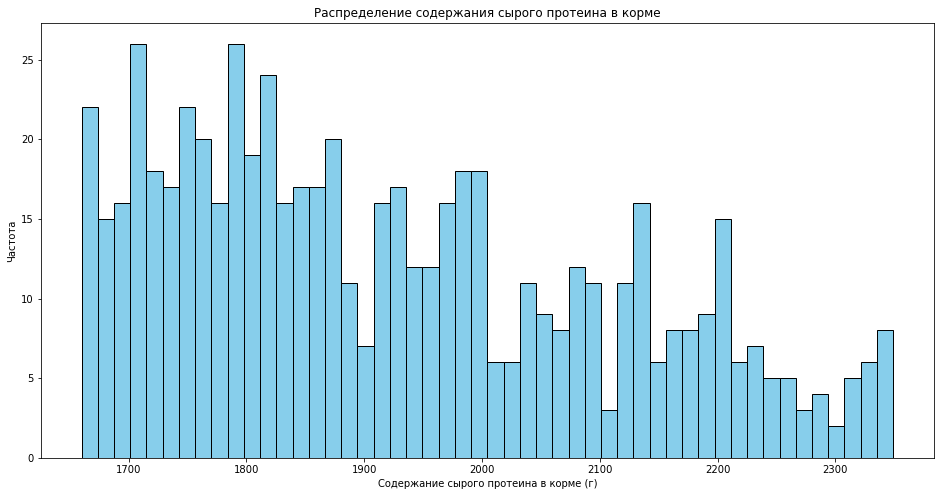

In [191]:
plt.figure(figsize=(16, 8))
plt.hist(ferma_main['сырой_протеин'], color='skyblue', edgecolor='black', bins=50)
plt.title('Распределение содержания сырого протеина в корме')
plt.xlabel('Содержание сырого протеина в корме (г)')
plt.ylabel('Частота')
plt.show()

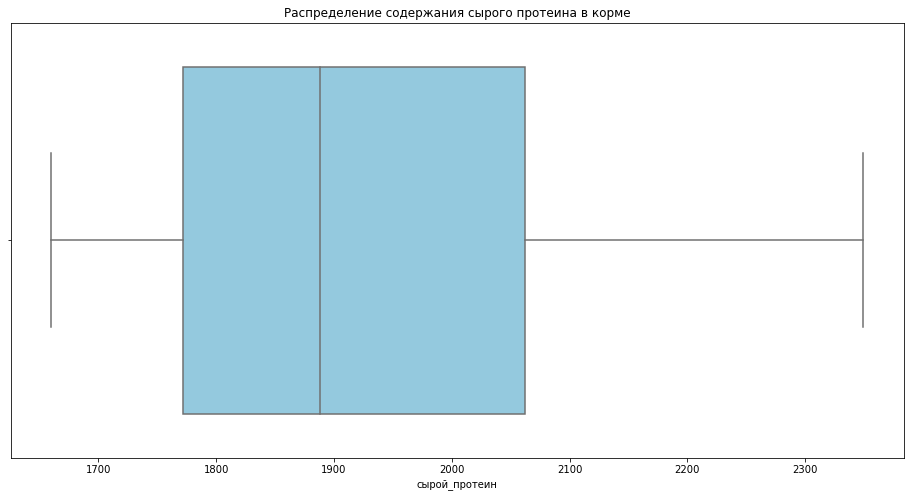

In [192]:
plt.figure(figsize=(16, 8))
sns.boxplot(x=ferma_main['сырой_протеин'], color='skyblue')
plt.title('Распределение содержания сырого протеина в корме')
plt.show()

Распределение сырого протеина не является нормальным, оно сильно варьируется по частоте в разных диапазонах. Распределение сдвинуто влево, в основном содержание сырого протеина в кормах меньше 2100. Медианное значение - 1888 г. 

Видны несколько пиков (например, около 1700 г, 1800 г, 2000 г и 2200 г). Эти пики могут быть связаны с различными типами кормов, которые имеют определенное содержание сырого протеина и используются более часто. 

### спо

In [193]:
ferma_main['спо'].describe()

count    628.000000
mean       0.913089
std        0.032221
min        0.840000
25%        0.890000
50%        0.930000
75%        0.940000
max        0.960000
Name: спо, dtype: float64

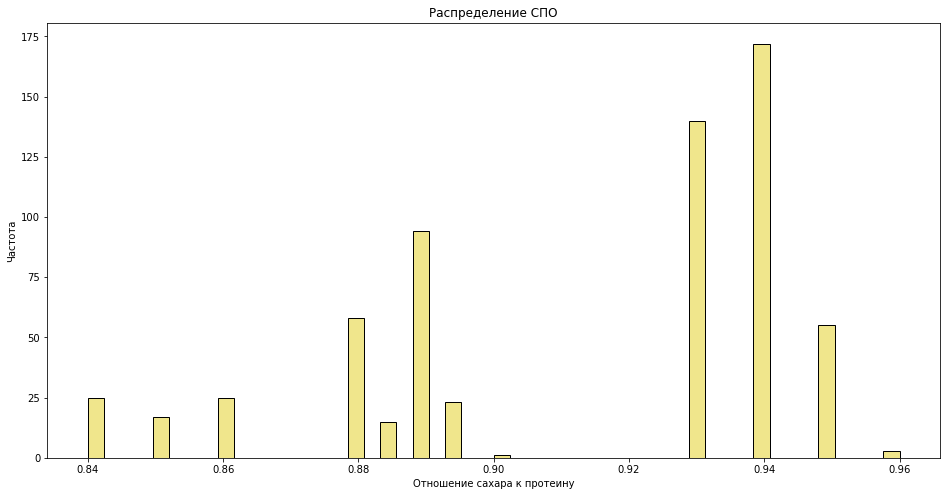

In [194]:
plt.figure(figsize=(16, 8))
plt.hist(ferma_main['спо'], color='khaki', edgecolor='black', bins=50)
plt.title('Распределение СПО')
plt.xlabel('Отношение сахара к протеину')
plt.ylabel('Частота')
plt.show()

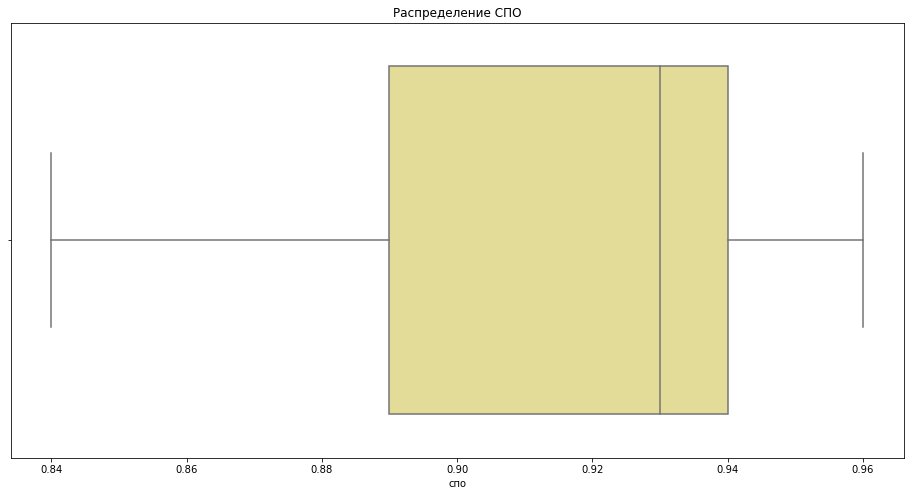

In [195]:
plt.figure(figsize=(16, 8))
sns.boxplot(x=ferma_main['спо'], color='khaki')
plt.title('Распределение СПО')
plt.show()

Самое частое значение СПО - 0.94, очень близкое к медиане. СПО 0.90 и 0.96 почти не встречается, что может быть объяснено особенностями кормов: такие используются намного реже остальных. 

### жирность

In [196]:
ferma_main['жирность'].describe()

count    628.000000
mean       3.604268
std        0.168093
min        2.990000
25%        3.590000
50%        3.650000
75%        3.720000
max        3.750000
Name: жирность, dtype: float64

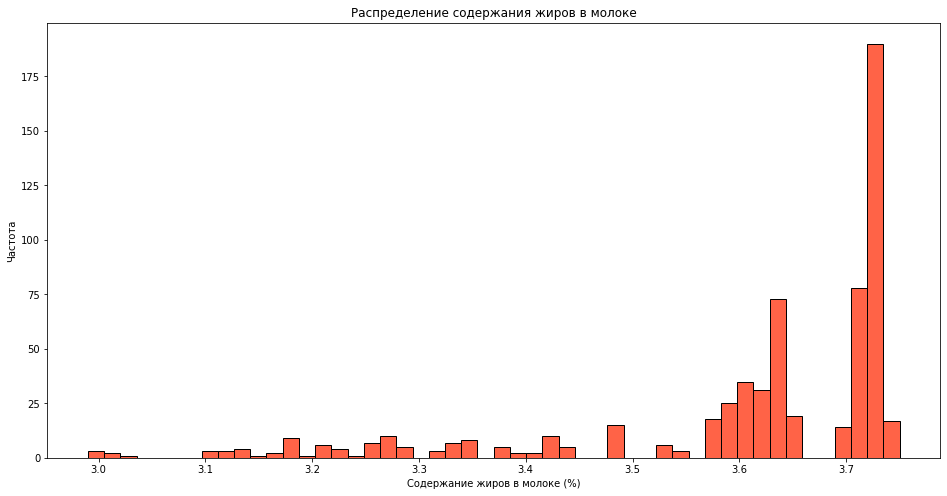

In [197]:
plt.figure(figsize=(16, 8))
plt.hist(ferma_main['жирность'], color='tomato', edgecolor='black', bins=50)
plt.title('Распределение содержания жиров в молоке')
plt.xlabel('Содержание жиров в молоке (%)')
plt.ylabel('Частота')
plt.show()

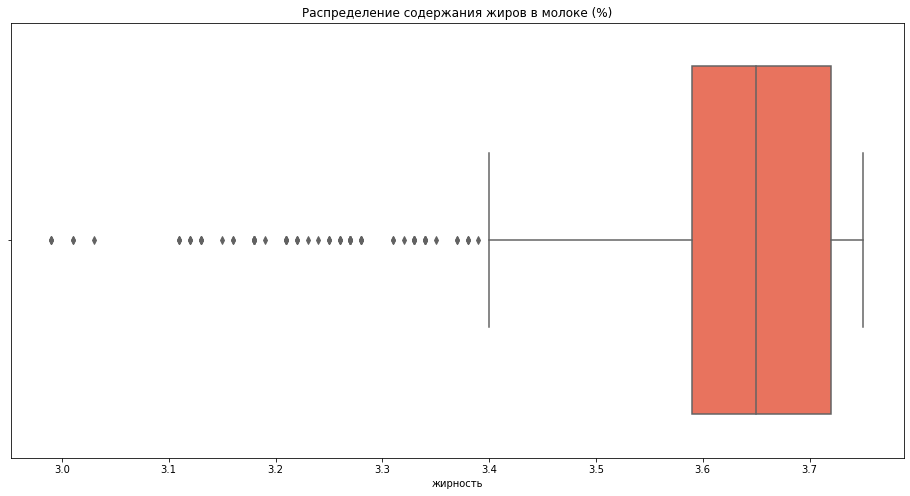

In [198]:
plt.figure(figsize=(16, 8))
sns.boxplot(x=ferma_main['жирность'], color='tomato')
plt.title('Распределение содержания жиров в молоке (%)')
plt.show()

Самая частая жирность молока - 3.6-3.7 %. Медианное значение - 3.65 %. 

На ящике с усами видно, что выбросов с жирностью < 3.4% достаточно много. Посмотрим сколько их в процентном соотношении, чтобы понять, можно ли их удалить:

In [199]:
round(len(ferma_main.query("жирность < 3.4")) / len(ferma_main), 2)

0.14

14% от общих данных - слишком много, чтобы удалить без последствий для качества датасета. Пока оставим как есть.

### белок

In [200]:
ferma_main['белок'].describe()

count    628.000000
mean       3.075670
std        0.002551
min        3.069000
25%        3.074000
50%        3.076000
75%        3.077000
max        3.085000
Name: белок, dtype: float64

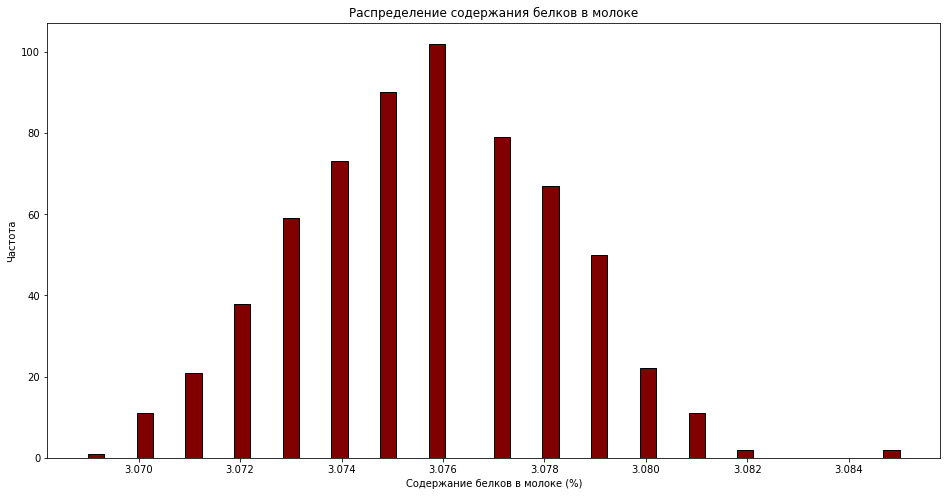

In [201]:
plt.figure(figsize=(16, 8))
plt.hist(ferma_main['белок'], color='maroon', edgecolor='black', bins=50)
plt.title('Распределение содержания белков в молоке')
plt.xlabel('Содержание белков в молоке (%)')
plt.ylabel('Частота')
plt.show()

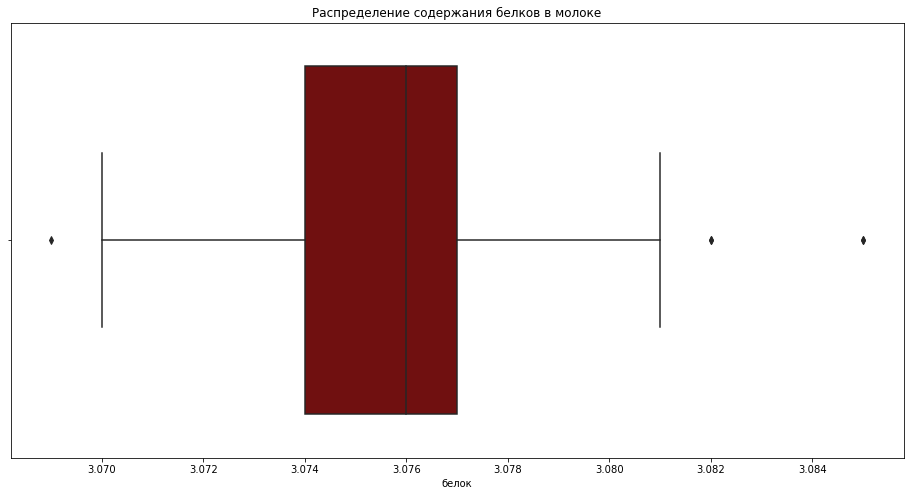

In [202]:
plt.figure(figsize=(16, 8))
sns.boxplot(x=ferma_main['белок'], color='maroon')
plt.title('Распределение содержания белков в молоке')
plt.show()

Распределение похоже на нормальное. Самое частое значение белка в молоке, а также медиана - 3.076, в основном от 3.074 до 3.077. 

На боксплоте видно несколько выбросов меньше 3.070 % и больше 3.081 %. Аналогично, посмотрим сколько их в процентном соотношении. 

In [203]:
print("Белки < 3.070:", round(len(ferma_main.query('белок < 3.070')) / len(ferma_main), 3))
print("Белки > 3.081:", round(len(ferma_main.query('белок > 3.081')) / len(ferma_main), 3))

Белки < 3.070: 0.002
Белки > 3.081: 0.006


Значения совсем крошечные, выбросы можно удалить без опасений. 

In [204]:
ferma_main.drop(ferma_main[(ferma_main['белок'] < 3.070) | (ferma_main['белок'] > 3.081)].index, inplace=True)

## Категориальные признаки

### порода

In [205]:
ferma_main['порода'].value_counts()

Вис Бик Айдиал     368
РефлешнСоверинг    255
Name: порода, dtype: int64

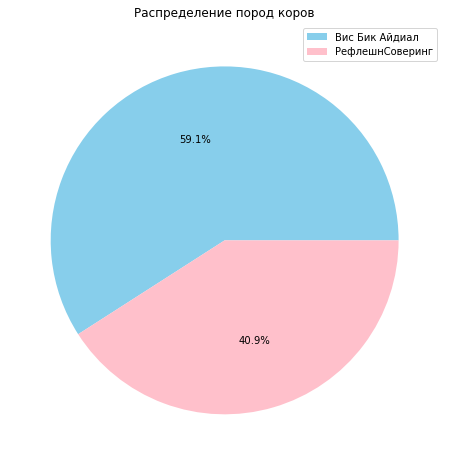

In [206]:
plt.figure(figsize=(16, 8))
plt.pie(ferma_main['порода'].value_counts(), autopct='%1.1f%%', colors=['skyblue', 'pink'])
plt.title('Распределение пород коров')
plt.legend(ferma_main['порода'].value_counts().index, loc='best')
plt.show()

Распределение пород стремится к соотношению 60:40 с бОльшей частотой встречи у Вис Бик Айдиал. 

### тип_пастбища

In [207]:
ferma_main['тип_пастбища'].value_counts()

холмистое    348
равнинное    275
Name: тип_пастбища, dtype: int64

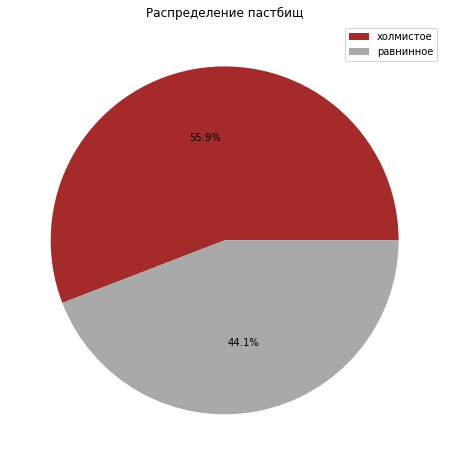

In [208]:
plt.figure(figsize=(16, 8))
plt.pie(ferma_main['тип_пастбища'].value_counts(), autopct='%1.1f%%', colors=['brown', 'darkgrey'])
plt.title('Распределение пастбищ')
plt.legend(ferma_main['тип_пастбища'].value_counts().index, loc='best')
plt.show()

Соотношение пастбищ похоже на соотношение пород. Холмистых пастбищ - 55.9%, равнинных - 44.1 %.

### порода_папы_быка

In [209]:
ferma_main['порода_папы_быка'].value_counts()

Айдиал     314
Соверин    309
Name: порода_папы_быка, dtype: int64

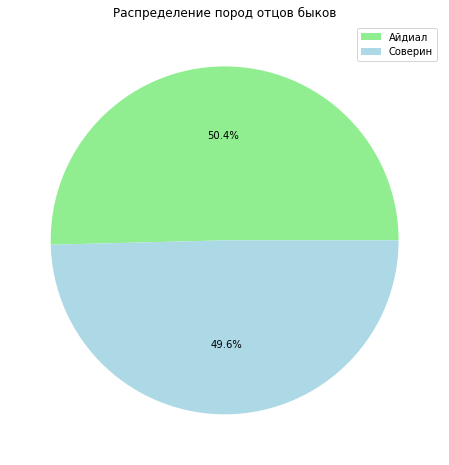

In [210]:
plt.figure(figsize=(16, 8))
plt.pie(ferma_main['порода_папы_быка'].value_counts(), autopct='%1.1f%%', colors=['lightgreen', 'lightblue'])
plt.title('Распределение пород отцов быков')
plt.legend(ferma_main['порода_папы_быка'].value_counts().index, loc='best')
plt.show()

Соотношение пород родителя быков практически 1:1. 50.4 % - пород Айдиал, 49.6% - пород Соверин. Учитывая распределение пород быков, количественно порода Айдиал имеет больше потомства. 

### вкус_молока

In [211]:
ferma_main['вкус_молока'].value_counts()

вкусно       366
не вкусно    257
Name: вкус_молока, dtype: int64

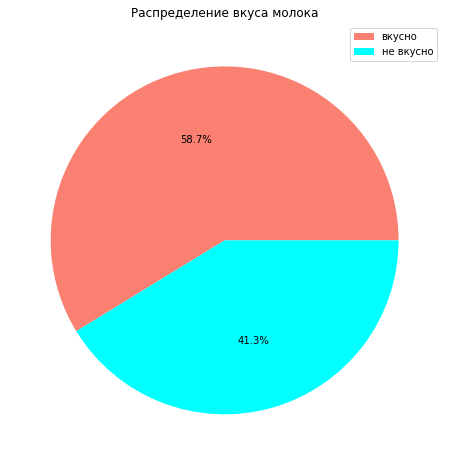

In [212]:
plt.figure(figsize=(16, 8))
plt.pie(ferma_main['вкус_молока'].value_counts(), autopct='%1.1f%%', colors=['salmon', 'cyan'])
plt.title('Распределение вкуса молока')
plt.legend(ferma_main['вкус_молока'].value_counts().index, loc='best')
plt.show()

В 58.7% молоко вкусное, но аж в 41.3% - нет. Учитывая, что нам нужно выбрать только коров, которые дают вкусное молоко, это важный показатель

### возраст

In [213]:
ferma_main['возраст'].value_counts()

более_2_лет    514
менее_2_лет    109
Name: возраст, dtype: int64

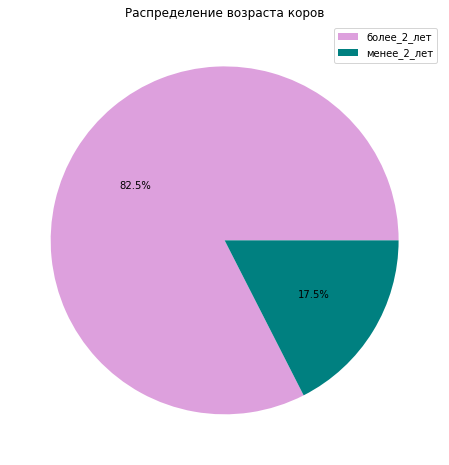

In [214]:
plt.figure(figsize=(16, 8))
plt.pie(ferma_main['возраст'].value_counts(), autopct='%1.1f%%', colors=['plum', 'teal'])
plt.title('Распределение возраста коров')
plt.legend(ferma_main['возраст'].value_counts().index, loc='best')
plt.show()

Большинству коров (82.5 %) более 2 лет, менее 2 лет же всего лишь 17.5 % коров. 

## Вывод

**Удой**: Большинство коров производят от 5750 до 6500 килограммов молока, и средний показатель составляет 6132 килограмма. 

**Питательность кормов**: Корма имеют питательную ценность от 13.5 до 15.5, со средней величиной 14.7. 

**Содержание сырого протеина**: Средний уровень протеина составляет 1888 граммов, и большинство кормов имеют содержание менее 2100 граммов. Мы видим несколько пиков, которые, вероятно, связаны с использованием разных типов кормов. 

**Сухое обезжиренное молоко (СПО)**: Наиболее распространенное значение составляет 0.94, что совпадает с медианой. 

**Жирность молока**: Средний показатель жирности составляет 3.65%, но стоит отметить, что в 14% случаев жирность ниже 3.4%. Это может указывать на необходимость улучшения рациона коров, чтобы повысить качество молока. 

**Содержание белка в молоке**: Среднее значение белка составляет 3.076%. 

**Породы коров**: Примерно 60% коров – это Вис Бик Айдиал, что может означать, что фермеры предпочитают именно эту породу. 

**Пастбища**: На ферме преобладают холмистые пастбища (55.9%), что может влиять на рацион коров и на качество молока. 

**Породы родителя быков**: Соотношение между породами Айдиал и Соверин близко к 1:1, с небольшим перевесом в пользу Айдиал. 

**Качество молока**: Только 58.7% молока считается вкусным. 

Средняя корова на ферме — это зрелая особь породы Вис Бик Айдиал, производящая около 6132 кг молока в год с жирностью 3.65%, а ее корм отличается стабильной питательной ценностью с содержанием сырого протеина около 1888 г.

# Корреляционный анализ

## Коэффициенты корреляции между всеми признаками

interval columns not set, guessing: ['id', 'удой', 'эке', 'сырой_протеин', 'спо', 'жирность', 'белок']


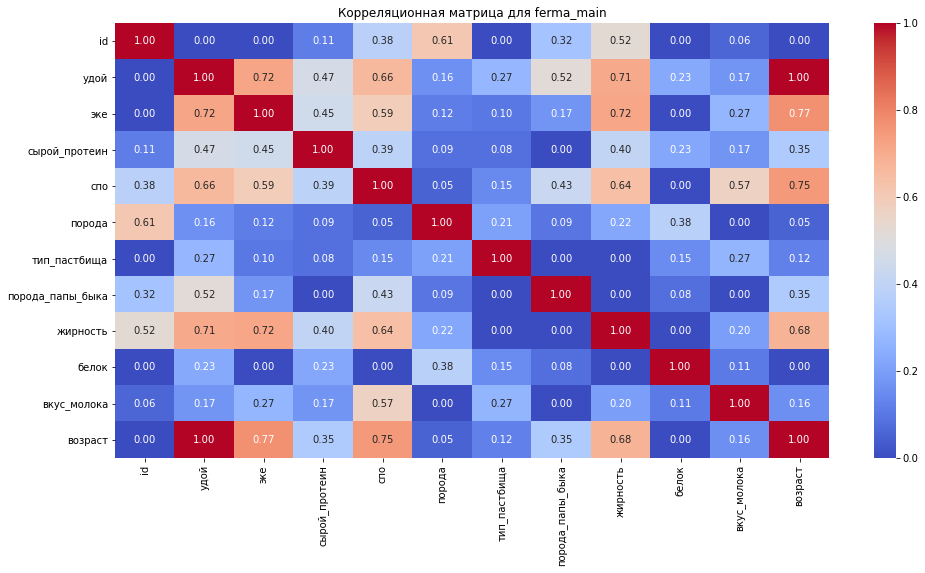

In [215]:
matrix = ferma_main.phik_matrix()

plt.figure(figsize=(16, 8))
sns.heatmap(matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Корреляционная матрица для ferma_main")
plt.show()

Интерпретируя коэффициенты корреляции, можно сказать, что входные признаки ЭКЕ и Жирность имеют самую большую связь с Удоем. Однако жирность - это характеристика самого молока, т.е. удоя и полезной информации сильная корреляция в данном случае не несет. 

Заметную корреляцию можно наблюдать так же между СПО и породой папы быка. Самая высокая зависимость - между возрастом и удоем, что позволяет говорить о мультиколлинеарности. Таким образом, ключевое влияние на количество удоя имеют ЭКЕ, СПО (т.е. корм коровы), возраст и порода папы быка. 

## Диаграммы рассеяния

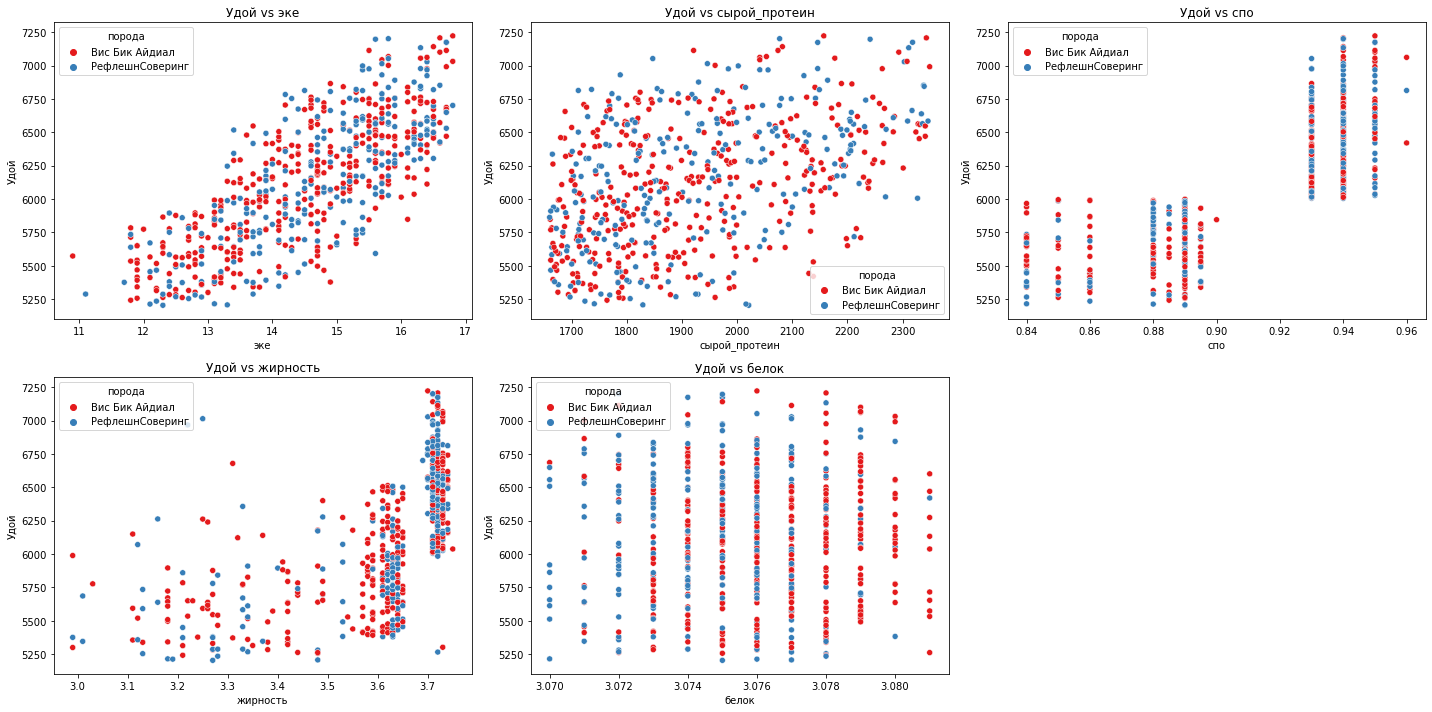

In [216]:
quantitative_scatter = ['эке', 'сырой_протеин', 'спо', 'жирность', 'белок']

plt.figure(figsize=(20, 10))

for i, feature in enumerate(quantitative_scatter, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=ferma_main, x=feature, y='удой', hue='порода', palette='Set1')
    plt.title(f'Удой vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Удой')

# отключение неиспользуемой оси
if len(quantitative_scatter) % 3 != 0:
    plt.subplot(2, 3, len(quantitative_scatter) + 1)
    plt.axis('off')

plt.tight_layout()
plt.show()

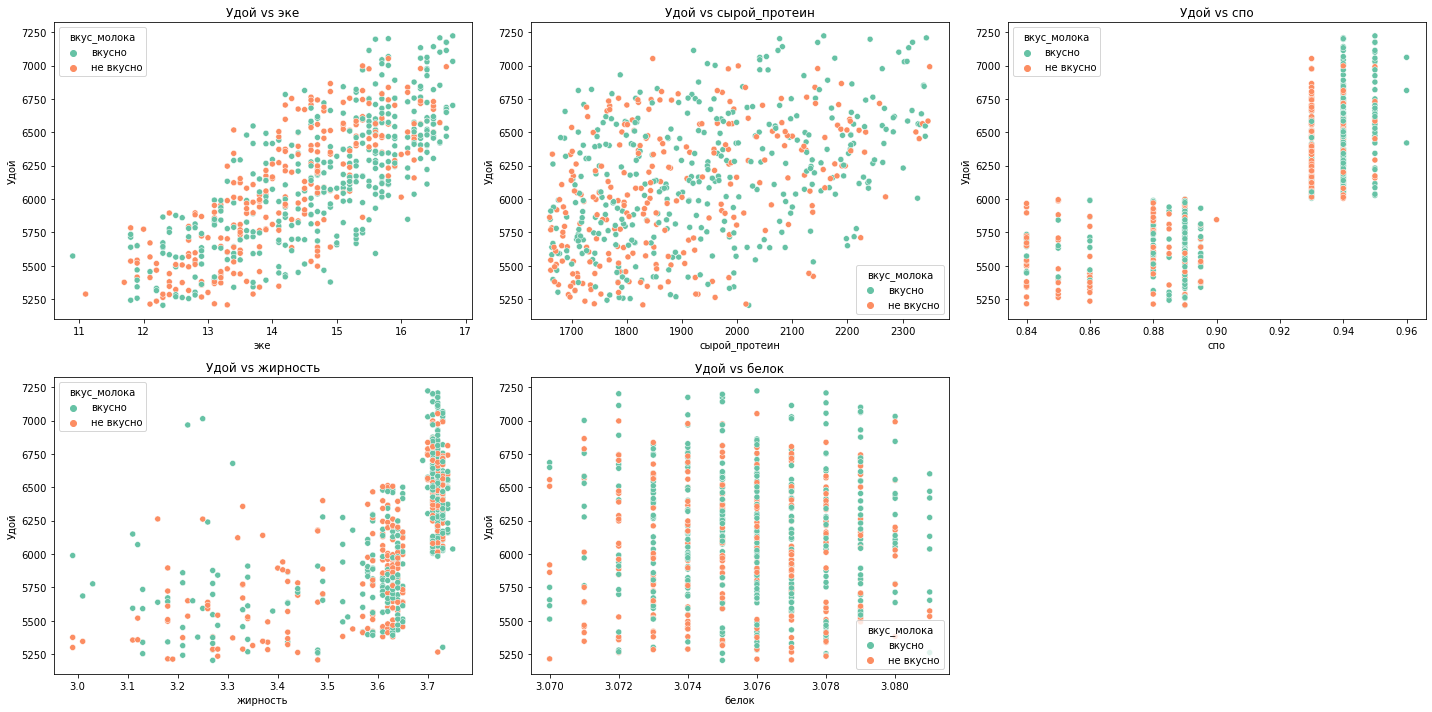

In [217]:
quantitative_scatter = ['эке', 'сырой_протеин', 'спо', 'жирность', 'белок']

plt.figure(figsize=(20, 10))

for i, feature in enumerate(quantitative_scatter, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=ferma_main, x=feature, y='удой', hue='вкус_молока', palette='Set2')
    plt.title(f'Удой vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Удой')

# отключение неиспользуемой оси
if len(quantitative_scatter) % 3 != 0:
    plt.subplot(2, 3, len(quantitative_scatter) + 1)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Вывод:

1. Из первой диаграммы рассеяния видно, что между ЭКЕ и Удой есть положительная линейная связь. По мере увеличения ЭКЕ, удой коров также увеличивается. Эта связь проявляется для обеих пород ("Вис Бик Айдиал" и "РефлешнСоверинг") и не зависит от вкуса молока. 

2. Диаграмма рассеяния сырого протеина показывает более разбросанные точки, что указывает на менее очевидную связь, однако, тренд виден. Связь по матрице корреляции также слабая. 

3. Корреляция СПО равна 0.66, что говорит об умеренной связи. Диаграмма рассеяния показывает группирование данных по значению СПО, что может говорить о влиянии категориального признака и нелинейной связи. 

4. Корреляция жирности и удоя высока, однако скорее всего при работе сработал принцип чем больше молока выдает корова, тем больше жирность. 

5. Удой и белок имеют очень слабую корреляцию, зависимость нелинейная, но исправлять ее не будем: белок - характеристика молока.

Ключевое влияние на количество удоя имеют ЭКЕ, СПО (т.е. корм коровы), возраст и порода папы быка.

# Обучение модели линейной регрессии

In [218]:
# расчет метрик

def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return mse, mae, rmse

## Модель 1

Удалим белок и жирность из нового датасета. Это характеристики молока, нас же интересует столбец только о его вкусе. 

In [219]:
ferma = ferma_main.drop(['id', 'белок', 'жирность', 'вкус_молока'], axis=1)

In [220]:
# создание модели

RANDOM_STATE = 42

X = ferma.drop('удой', axis = 1)
y = ferma['удой']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

In [221]:
quantitative = ['эке', 'сырой_протеин', 'спо']
categoriсal = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст']

# масштабирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[quantitative])
X_test_scaled = scaler.transform(X_test[quantitative])

# кодирование
encoder = OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore')
X_train_ohe = encoder.fit_transform(X_train[categoriсal])
X_test_ohe = encoder.transform(X_test[categoriсal])

ohe_columns = encoder.get_feature_names(categoriсal)

X_train_ohe = pd.DataFrame(X_train_ohe, columns=ohe_columns)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=ohe_columns)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=quantitative)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=quantitative)

# объединяем
X_train = pd.concat([X_train_scaled, X_train_ohe], axis=1)
X_test = pd.concat([X_test_scaled, X_test_ohe], axis=1)

print(X_train.head())
print(X_test.head())

        эке  сырой_протеин       спо  порода_РефлешнСоверинг  \
0  1.543027       0.206082  1.426018                     0.0   
1  1.388625      -0.185338  0.795084                     0.0   
2 -0.386997       0.265882 -0.782250                     0.0   
3 -0.927403      -0.832267 -1.097716                     1.0   
4  0.076209      -1.397651 -1.097716                     0.0   

   тип_пастбища_холмистое  порода_папы_быка_Соверин  возраст_менее_2_лет  
0                     0.0                       1.0                  0.0  
1                     0.0                       0.0                  0.0  
2                     0.0                       0.0                  0.0  
3                     0.0                       0.0                  0.0  
4                     0.0                       0.0                  0.0  
        эке  сырой_протеин       спо  порода_РефлешнСоверинг  \
0 -0.695800       0.091918 -0.782250                     1.0   
1 -2.085417      -1.446578 -2.359584 

D:\anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [222]:
model_lr1 = LinearRegression() 
model_lr1.fit(X_train, y_train)
y_pred = model_lr1.predict(X_test)

R²: 0.783


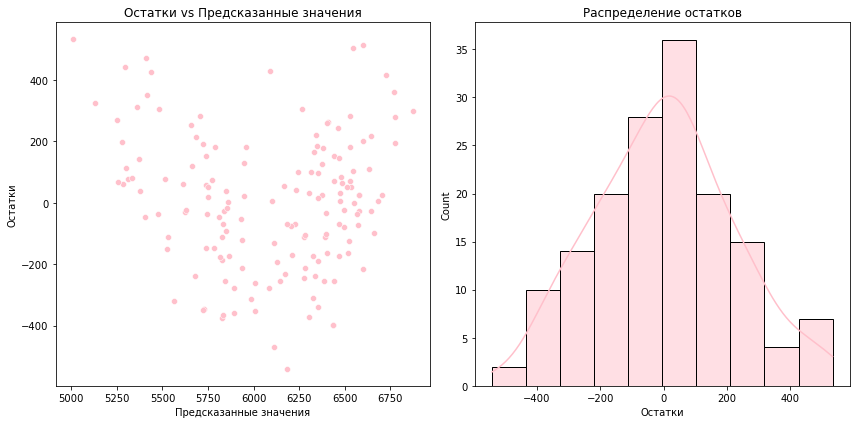

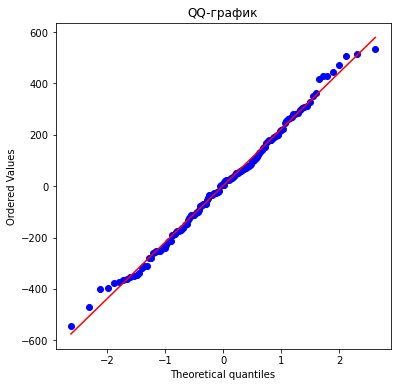

In [223]:
r2_1 = r2_score(y_test, y_pred)
print(f"R²: {r2_1:.3f}")

residuals_1 = y_test - y_pred

plt.figure(figsize=(12, 6))

# сравнение остатков и предсказанных значений
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_pred, y=residuals_1, color='pink')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('Остатки vs Предсказанные значения')

# распределение остатков
plt.subplot(1, 2, 2)
sns.histplot(residuals_1, color='pink', kde=True)
plt.xlabel('Остатки')
plt.title('Распределение остатков')

plt.tight_layout()
plt.show()

# QQ-график для проверки нормальности остатков
plt.figure(figsize=(6, 6))
stats.probplot(residuals_1, dist="norm", plot=plt)
plt.title('QQ-график')
plt.show()

In [224]:
mse_1, mae_1, rmse_1 = calculate_metrics(y_test, model_lr1.predict(X_test))
mse_1, mae_1, rmse_1

(47499.99945525989, 173.8012231473742, 217.94494592731414)

### Вывод

Значение r2-score = 0.783. Практически в 80% случаев предсказание модели точнее, чем среднее значение целевого признака. 
mse_1 = 47500, mae_1 = 173.8, rmse_1 = 217.9


На графике рассеивания остатки расположены достаточно хаотично, закономерности отсутствуют. Распределение близко к нормальному, но наблюдаются некоторые отклонения. График QQ сравнивает распределение остатков с нормальным распределением: если остатки следуют нормальному распределению, точки будут лежать на прямой линии. Как мы видим, точки лежат на прямой, но есть некоторые проблемы на концах, что может указывать на наличие экстремальных значений.

## Модель 2

Вспомним информацию о СПО:

In [225]:
ferma_main['спо'].describe()

count    623.000000
mean       0.913283
std        0.032150
min        0.840000
25%        0.890000
50%        0.930000
75%        0.940000
max        0.960000
Name: спо, dtype: float64

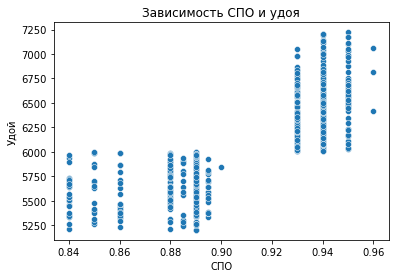

In [226]:
sns.scatterplot(x=ferma_main['спо'], y=ferma_main['удой'])
plt.xlabel('СПО')
plt.ylabel('Удой')
plt.title('Зависимость СПО и удоя')
plt.show()

Граница между кластерами на графике рассеивания СПО примерно находится в области между 0.90 и 0.92. На основании этого, границу для преобразования СПО в бинарный признак можно установить на уровне 0.91 - среднее значение.

In [227]:
ferma_2 = ferma_main.copy(deep=True)

In [228]:
spo_boundary = 0.92
ferma_2['спо_бинар'] = (ferma_2['спо'] > spo_boundary).astype(int)

# возводим эке в квадрат и удаляем ненужны столбцы
ferma_2['эке_квадрат'] = ferma_2['эке'] ** 2
ferma_2.drop(['id', 'белок', 'жирность', 'эке', 'спо', 'вкус_молока'], axis=1, inplace=True)

In [229]:
ferma_2.head(10)

,удой,сырой_протеин,порода,тип_пастбища,порода_папы_быка,возраст,спо_бинар,эке_квадрат
0,5863,1743,Вис Бик Айдиал,равнинное,Айдиал,более_2_лет,0,201.64
1,5529,2138,Вис Бик Айдиал,равнинное,Соверин,менее_2_лет,0,163.84
2,5810,1854,РефлешнСоверинг,холмистое,Соверин,более_2_лет,0,196.00
3,5895,2012,РефлешнСоверинг,холмистое,Айдиал,более_2_лет,0,153.76
4,5302,1675,Вис Бик Айдиал,равнинное,Соверин,менее_2_лет,0,163.84
5,5254,1806,РефлешнСоверинг,холмистое,Соверин,менее_2_лет,0,161.29
6,5910,1792,Вис Бик Айдиал,равнинное,Соверин,более_2_лет,0,174.24
7,6179,1806,Вис Бик Айдиал,равнинное,Айдиал,более_2_лет,1,216.09
8,6783,1918,РефлешнСоверинг,холмистое,Айдиал,более_2_лет,1,201.64
9,5339,1791,Вис Бик Айдиал,холмистое,Соверин,менее_2_лет,0,179.56


In [230]:
# строим модель

RANDOM_STATE = 42

X = ferma_2.drop('удой', axis = 1)
y = ferma_2['удой']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

In [231]:
quantitative = ['эке_квадрат', 'спо_бинар', 'сырой_протеин']
categoriсal = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст']

# масштабирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[quantitative])
X_test_scaled = scaler.transform(X_test[quantitative])

# кодирование
encoder = OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore')
X_train_ohe = encoder.fit_transform(X_train[categoriсal])
X_test_ohe = encoder.transform(X_test[categoriсal])

ohe_columns = encoder.get_feature_names(categoriсal)

X_train_ohe = pd.DataFrame(X_train_ohe, columns=ohe_columns)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=ohe_columns)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=quantitative)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=quantitative)

# объединяем
X_train = pd.concat([X_train_scaled, X_train_ohe], axis=1)
X_test = pd.concat([X_test_scaled, X_test_ohe], axis=1)

print(X_train.head())
print(X_test.head())

   эке_квадрат  спо_бинар  сырой_протеин  порода_РефлешнСоверинг  \
0     1.626057   0.791946       0.206082                     0.0   
1     1.449208   0.791946      -0.185338                     0.0   
2    -0.430475  -1.262713       0.265882                     0.0   
3    -0.946283  -1.262713      -0.832267                     1.0   
4     0.032546  -1.262713      -1.397651                     0.0   

   тип_пастбища_холмистое  порода_папы_быка_Соверин  возраст_менее_2_лет  
0                     0.0                       1.0                  0.0  
1                     0.0                       0.0                  0.0  
2                     0.0                       0.0                  0.0  
3                     0.0                       0.0                  0.0  
4                     0.0                       0.0                  0.0  
   эке_квадрат  спо_бинар  сырой_протеин  порода_РефлешнСоверинг  \
0    -0.728438  -1.262713       0.091918                     1.0   
1    

D:\anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [232]:
model_lr2 = LinearRegression() 
model_lr2.fit(X_train, y_train)
y_pred = model_lr2.predict(X_test)

R²: 0.835


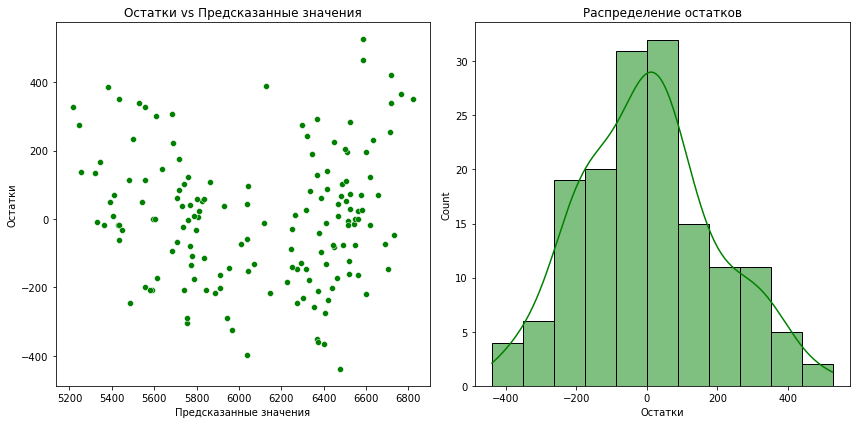

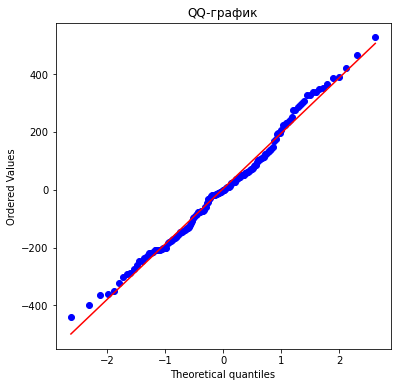

In [233]:
r2_2 = r2_score(y_test, y_pred)
print(f"R²: {r2_2:.3f}")

residuals_2 = y_test - y_pred

plt.figure(figsize=(12, 6))

# сравнение остатков и предсказанных значений
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_pred, y=residuals_2, color='green')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('Остатки vs Предсказанные значения')

# распределение остатков
plt.subplot(1, 2, 2)
sns.histplot(residuals_2, color='green', kde=True)
plt.xlabel('Остатки')
plt.title('Распределение остатков')

plt.tight_layout()
plt.show()

# QQ-график для проверки нормальности остатков
plt.figure(figsize=(6, 6))
stats.probplot(residuals_2, dist="norm", plot=plt)
plt.title('QQ-график')
plt.show()

In [234]:
mse_2, mae_2, rmse_2 = calculate_metrics(y_test, model_lr2.predict(X_test))
mse_2, mae_2, rmse_2

(36207.49001635706, 149.7197997704034, 190.28265821234749)

### Вывод

R²: 0.835, mse_2 = 36207.5, mae_2 = 149.7, rmse_2 = 190.3

Предсказания разбросаны довольно хаотично, разделение на правый и левый кластер уже менее четкое, чем в первой модели. Распределение похоже на нормальное, но есть несколько пиков слева. 

## Модель 3

In [235]:
# объединяем с породами пап быков

ferma_3 = ferma_main.merge(ferma_dad, on='id')
ferma_3.head(10)

,id,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст,имя_папы_быка
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,Буйный
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,Соловчик
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,Барин
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,Буйный
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,Барин
5,6,5254,12.7,1806,0.885,РефлешнСоверинг,холмистое,Соверин,3.13,3.078,вкусно,менее_2_лет,Барин
6,7,5910,13.2,1792,0.885,Вис Бик Айдиал,равнинное,Соверин,3.48,3.077,вкусно,более_2_лет,Соловчик
7,8,6179,14.7,1806,0.930,Вис Бик Айдиал,равнинное,Айдиал,3.55,3.076,вкусно,более_2_лет,Геркулес
8,9,6783,14.2,1918,0.940,РефлешнСоверинг,холмистое,Айдиал,3.71,3.077,вкусно,более_2_лет,Буйный
9,10,5339,13.4,1791,0.895,Вис Бик Айдиал,холмистое,Соверин,3.13,3.075,вкусно,менее_2_лет,Барин


In [236]:
# избавляемся от нелинейности

spo_boundary = 0.92
ferma_3['спо_бинар'] = (ferma_3['спо'] > spo_boundary).astype(int)

ferma_3['эке_квадрат'] = ferma_3['эке'] ** 2
ferma_3.drop(['id', 'белок', 'жирность', 'эке', 'спо', 'вкус_молока'], axis=1, inplace=True)

In [237]:
ferma_3.head(10)

,удой,сырой_протеин,порода,тип_пастбища,порода_папы_быка,возраст,имя_папы_быка,спо_бинар,эке_квадрат
0,5863,1743,Вис Бик Айдиал,равнинное,Айдиал,более_2_лет,Буйный,0,201.64
1,5529,2138,Вис Бик Айдиал,равнинное,Соверин,менее_2_лет,Соловчик,0,163.84
2,5810,1854,РефлешнСоверинг,холмистое,Соверин,более_2_лет,Барин,0,196.00
3,5895,2012,РефлешнСоверинг,холмистое,Айдиал,более_2_лет,Буйный,0,153.76
4,5302,1675,Вис Бик Айдиал,равнинное,Соверин,менее_2_лет,Барин,0,163.84
5,5254,1806,РефлешнСоверинг,холмистое,Соверин,менее_2_лет,Барин,0,161.29
6,5910,1792,Вис Бик Айдиал,равнинное,Соверин,более_2_лет,Соловчик,0,174.24
7,6179,1806,Вис Бик Айдиал,равнинное,Айдиал,более_2_лет,Геркулес,1,216.09
8,6783,1918,РефлешнСоверинг,холмистое,Айдиал,более_2_лет,Буйный,1,201.64
9,5339,1791,Вис Бик Айдиал,холмистое,Соверин,менее_2_лет,Барин,0,179.56


In [238]:
# строим модель

RANDOM_STATE = 42

X = ferma_3.drop('удой', axis = 1)
y = ferma_3['удой']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

In [239]:
# понадобится для финальной модели

X_train_full = pd.concat([X_train, X_test], ignore_index=True)
y_train_full = pd.concat([y_train, y_test], ignore_index=True)

In [240]:
quantitative = ['эке_квадрат', 'сырой_протеин', 'спо_бинар']
categoriсal = ['порода', 'тип_пастбища', 'порода_папы_быка', 'имя_папы_быка', 'возраст']

# масштабирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[quantitative])
X_test_scaled = scaler.transform(X_test[quantitative])

# кодирование
encoder = OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore')
X_train_ohe = encoder.fit_transform(X_train[categoriсal])
X_test_ohe = encoder.transform(X_test[categoriсal])

ohe_columns = encoder.get_feature_names()

X_train_ohe = pd.DataFrame(X_train_ohe, columns=ohe_columns)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=ohe_columns)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=quantitative)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=quantitative)

# объединяем
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

print(X_train.head())
print(X_test.head())

   x0_РефлешнСоверинг  x1_холмистое  x2_Соверин  x3_Буйный  x3_Геркулес  \
0                 0.0           0.0         1.0        0.0          0.0   
1                 0.0           0.0         0.0        1.0          0.0   
2                 0.0           0.0         0.0        1.0          0.0   
3                 1.0           0.0         0.0        0.0          1.0   
4                 0.0           0.0         0.0        1.0          0.0   

   x3_Соловчик  x4_менее_2_лет  эке_квадрат  сырой_протеин  спо_бинар  
0          0.0             0.0     1.626057       0.206082   0.791946  
1          0.0             0.0     1.449208      -0.185338   0.791946  
2          0.0             0.0    -0.430475       0.265882  -1.262713  
3          0.0             0.0    -0.946283      -0.832267  -1.262713  
4          0.0             0.0     0.032546      -1.397651  -1.262713  
   x0_РефлешнСоверинг  x1_холмистое  x2_Соверин  x3_Буйный  x3_Геркулес  \
0                 1.0           1.0       

D:\anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [241]:
model_lr3 = LinearRegression() 
model_lr3.fit(X_train, y_train)
y_pred = model_lr3.predict(X_test)

R²: 0.841


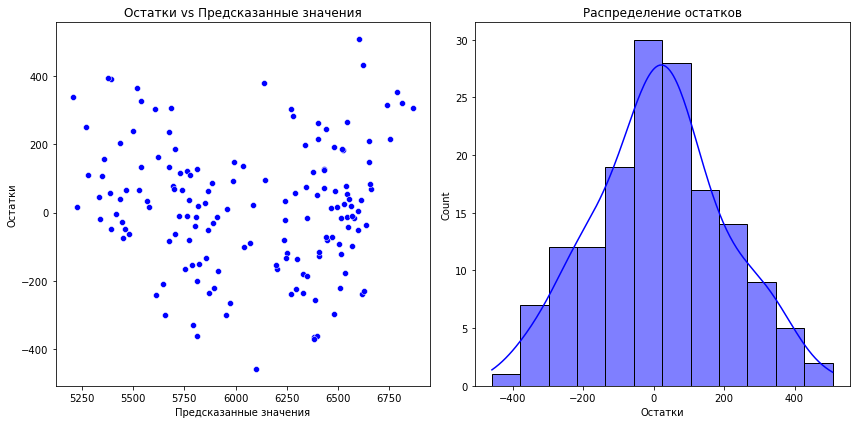

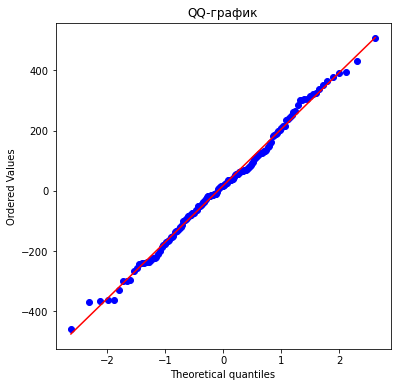

In [242]:
r2_3 = r2_score(y_test, y_pred)
print(f"R²: {r2_3:.3f}")

residuals_3 = y_test - y_pred

plt.figure(figsize=(12, 6))

# сравнение остатков и предсказанных значений
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_pred, y=residuals_3, color='blue')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('Остатки vs Предсказанные значения')

# распределение остатков
plt.subplot(1, 2, 2)
sns.histplot(residuals_3, color='blue', kde=True)
plt.xlabel('Остатки')
plt.title('Распределение остатков')

plt.tight_layout()
plt.show()

# QQ-график для проверки нормальности остатков
plt.figure(figsize=(6, 6))
stats.probplot(residuals_3, dist="norm", plot=plt)
plt.title('QQ-график')
plt.show()

In [243]:
mse_3, mae_3, rmse_3 = calculate_metrics(y_test, model_lr3.predict(X_test))
mse_3, mae_3, rmse_3

(34749.38198508258, 146.71660051937863, 186.41186117058803)

### Вывод

r2 = 0.841, mse_3 = 34749.4, mae_3 = 146.7, rmse_3 = 186.4

Предсказания разбросаны хаотично, распределение больше всего похоже на нормальное. 

## Сравнение 3х моделей

In [244]:
# сравнение r2 и остатков

print("Сравнение r2_score:")
for model, r2_score in zip(['1', '2', '3'], [r2_1, r2_2, r2_3]):
    print(f"Модель {model}:  {r2_score:.4f}")
print('\n')

print("Сравнение residuals:")
for model, residuals in zip(['1', '2', '3'], [residuals_1, residuals_2, residuals_3]):
    print(f"Модель {model}: {residuals.mean():.4f}")

Сравнение r2_score:
Модель 1:  0.7832
Модель 2:  0.8347
Модель 3:  0.8414


Сравнение residuals:
Модель 1: 1.6618
Модель 2: 3.7396
Модель 3: 16.9835


In [245]:
print("Сравнение метрик MSE, MAE, RMSE:")

for model, mse, mae, rmse in zip(
    ['1', '2', '3'], 
    [mse_1, mse_2, mse_3], 
    [mae_1, mae_2, mae_3], 
    [rmse_1, rmse_2, rmse_3]
):
    print(f"Модель {model}: MSE={mse:.4f}, MAE={mae:.4f}, RMSE={rmse:.4f}")

Сравнение метрик MSE, MAE, RMSE:
Модель 1: MSE=47499.9995, MAE=173.8012, RMSE=217.9449
Модель 2: MSE=36207.4900, MAE=149.7198, RMSE=190.2827
Модель 3: MSE=34749.3820, MAE=146.7166, RMSE=186.4119


Модель 3 является наилучшей моделью, поскольку она показывает самое близкое к 1 значение R2 и имеет наименьшие значения метрик MSE, RMSE и MAE. Стоит отметить, что у модели 1 наименьшее среднее значение остатков, что говорит о более сбалансированных предсказаниях, однако учитывая важность точности, модель 3 выглядит самой надежной. 

In [246]:
# поскольку модель 3 обучалась последней, в y_pred сохранились ее предсказания

print('Доверительный интервал для лучшей модели =', stats.norm.interval(confidence=0.95, loc=np.mean(y_pred), scale=stats.sem(y_pred)))

Доверительный интервал для лучшей модели = (6003.688125568126, 6141.703755012543)


## Итоговая модель линейной регрессии

In [247]:
cow_buy_lr = cow_buy.copy(deep=True)

In [248]:
values_extended = ferma_main[['эке', 'сырой_протеин', 'спо']].mean() * 1.05

cow_buy_lr['эке'] = values_extended['эке']
cow_buy_lr['эке_квадрат'] = cow_buy_lr['эке'] ** 2
cow_buy_lr['сырой_протеин'] = values_extended['сырой_протеин']
cow_buy_lr['спо'] = values_extended['спо']

spo_boundary = 0.92
cow_buy_lr['спо_бинар'] = (cow_buy_lr['спо'] > spo_boundary).astype(int)


cow_buy_lr.drop(['эке', 'спо', 'текущая_жирность', 'текущий_белок'], axis=1, inplace=True)
cow_buy_lr.head()

,порода,тип_пастбища,порода_папы_быка,имя_папы_быка,возраст,эке_квадрат,сырой_протеин,спо_бинар
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,более_2_лет,233.378833,2019.77191,1
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,менее_2_лет,233.378833,2019.77191,1
2,РефлешнСоверинг,равнинное,Соверин,Барин,более_2_лет,233.378833,2019.77191,1
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,более_2_лет,233.378833,2019.77191,1
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,более_2_лет,233.378833,2019.77191,1


In [249]:
#quantitative = ['эке_квадрат', 'сырой_протеин', 'спо_бинар']
#categoriсal = ['порода', 'тип_пастбища', 'порода_папы_быка', 'имя_папы_быка', 'возраст']

X_test_scaled = scaler.transform(cow_buy_lr[quantitative])
X_test_ohe = encoder.transform(cow_buy_lr[categoriсal])
encoder_col_names = encoder.get_feature_names_out()

X_test_scaled = pd.DataFrame(X_test_scaled, columns=quantitative)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_test_full = pd.concat([X_test_ohe, X_test_scaled], axis=1)

predictions_final = model_lr3.predict(X_test_full)
predictions_final

D:\anaconda\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- возраст_менее_2_лет
- имя_папы_быка_Буйный
- имя_папы_быка_Геркулес
- имя_папы_быка_Соловчик
- порода_РефлешнСоверинг
- ...
Feature names seen at fit time, yet now missing:
- x0_РефлешнСоверинг
- x1_холмистое
- x2_Соверин
- x3_Буйный
- x3_Геркулес
- ...

  warnings.warn(message, FutureWarning)


array([6609.25367288, 6358.10267231, 6283.59321351, 6599.11444126,
       6544.61992539, 6442.50025097, 6609.25367288, 6556.59715012,
       6283.59321351, 6400.61996346, 6334.07609338, 6640.99472878,
       6609.25367288, 6102.46407806, 6283.59321351, 6599.11444126,
       6334.07609338, 6442.50025097, 6556.59715012, 6544.61992539])

In [251]:
cow_buy['предсказанный_удой'] = predictions_final
cow_buy

,порода,тип_пастбища,порода_папы_быка,имя_папы_быка,текущая_жирность,текущий_белок,возраст,предсказанный_удой
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6609.253673
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,6358.102672
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,6283.593214
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,6599.114441
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,6544.619925
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,6442.500251
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6609.253673
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,6556.597150
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,6283.593214
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,6400.619963


## Вывод

После обучения трех разных моделей логистической регрессии, выявили лучшую модель с такими показателями: r2 = 0.841, mse_3 = 34749.4, mae_3 = 146.7, rmse_3 = 186.4. 

Используя ее, предсказали удой коров пастбища. На данный момент можем рекомендовать 20 коров, которые вероятнее всего дадут более 6000 кг удоя в год. Приступим к предсказанию вкуса молока.

# Обучение модели логистической регрессии

## Модель классификации

In [252]:
ferma_clf = ferma_main.copy(deep=True)

In [253]:
# преобразование признаков

spo_boundary = 0.92
ferma_clf['спо_бинар'] = (ferma_clf['спо'] > spo_boundary).astype(int)

ferma_clf['вкус_молока_бинар'] = ferma_clf['вкус_молока'].apply(lambda x: 1 if x == 'вкусно' else 0)

ferma_clf['эке_квадрат'] = ferma_clf['эке'] ** 2

ferma_clf.drop(['id', 'удой', 'спо', 'вкус_молока', 'эке'], axis=1, inplace=True)
ferma_clf.head()

,сырой_протеин,порода,тип_пастбища,порода_папы_быка,жирность,белок,возраст,спо_бинар,вкус_молока_бинар,эке_квадрат
0,1743,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,более_2_лет,0,1,201.64
1,2138,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,менее_2_лет,0,1,163.84
2,1854,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,более_2_лет,0,0,196.00
3,2012,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,более_2_лет,0,0,153.76
4,1675,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,менее_2_лет,0,1,163.84


In [254]:
# разбиваем данные на выборки

X = ferma_clf.drop('вкус_молока_бинар', axis=1)
y = ferma_clf['вкус_молока_бинар']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, stratify=y)

In [255]:
# объединенные тренировочные данные
X_train_full = pd.concat([X_train, X_test], ignore_index=True)
y_train_full = pd.concat([y_train, y_test], ignore_index=True)

In [256]:
quantitative = ['эке_квадрат', 'сырой_протеин', 'жирность', 'белок']
categoriсal = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст', 'спо_бинар']

# масштабирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[quantitative])
X_test_scaled = scaler.transform(X_test[quantitative])

# кодирование
encoder = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')
X_train_ohe = encoder.fit_transform(X_train[categoriсal])
X_test_ohe = encoder.transform(X_test[categoriсal])

encoder_col_names = encoder.get_feature_names()

# собираем воедино
X_train_scaled = pd.DataFrame(X_train_scaled, columns=quantitative)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=quantitative)

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

D:\anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [257]:
# обучаем модель
clf = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [258]:
# вычисляем метрики

accuracy = accuracy_score(y_pred, y_test)
recall = recall_score(y_pred, y_test)
precision = precision_score(y_pred, y_test)

print('Accuracy: ', accuracy)
print('Recall: ', recall)
print('Precision: ', precision)

Accuracy:  0.6538461538461539
Recall:  0.6637931034482759
Precision:  0.8369565217391305


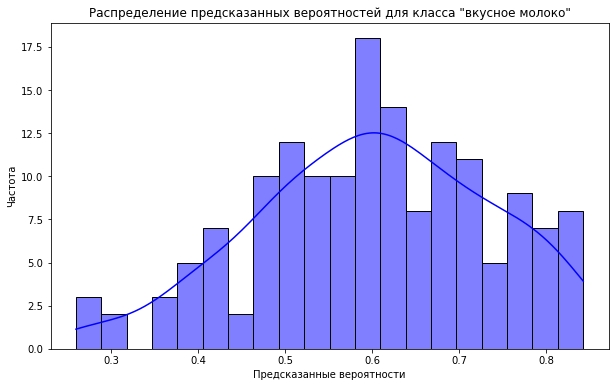

In [259]:
y_proba = clf.predict_proba(X_test)[:, 1]  # вероятности для класса 1 (вкусное молоко)

plt.figure(figsize=(10, 6))
sns.histplot(y_proba, bins=20, kde=True, color='blue')
plt.title('Распределение предсказанных вероятностей для класса "вкусное молоко"')
plt.xlabel('Предсказанные вероятности')
plt.ylabel('Частота')
plt.show()

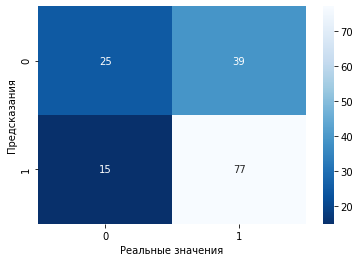

In [260]:
# матрица ошибок 

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.xlabel('Реальные значения')
plt.ylabel('Предсказания')
plt.show()

### Вывод

Вероятности на гистограмме распределены достаточно равномерно, но с некоторым смещением в сторону более высоких значений (около 0.6–0.7), что может говорить о том, что модель чаще склоняется к предсказанию того, что молоко будет вкусным. В то же время присутствует значительное количество предсказаний с вероятностями около 0.4–0.5, что может указывать на неопределенность модели в этих случаях. 

Матрица ошибок показывает, что модель допустила значительное количество ошибок, особенно с ложными отрицаниями (FN = 39). Это означает, что модель часто предсказывает, что молоко невкусное, хотя оно на самом деле вкусное. При этом число ложных положительных срабатываний (FP = 15) относительно меньше, что может говорить о склонности модели к осторожности. 

Кроме того, модель показывает не слишком высокие значения accuracy = 0.62 и recall= 0.625. Это указывает на то, что модель нуждается в улучшении, так как значительное количество случаев (около 38%) предсказаны неверно. Recall, который показывает способность модели обнаруживать истинные положительные случаи, также низок. Следует оптимизировать порог принятия решения.

## Анализ модели логистической регрессии

При покупке коров, главной целью является отбор таких коров, которые дают вкусное молоко => ошибка первого рода критичнее. Модель предскажет, что корова дает вкусное молоко, но на самом деле молоко невкусное, а фермер купит корову, которая вопреки ожиданиям не будет давать вкусное молоко. Это приведет к потере финансов на покупку и дополнительным затратам на содержание коров, которые не соответствуют требованиям. Пусть ошибка второго рода и приводит к упущению потенциально хорошей коровы, что нежелательно, но менее критично.

Самая важная для нас метрика - precision. Мы хотим минимизировать число ошибок первого рода, то есть увеличить точность предсказания. precision будет более важной метрикой в данном случае, т.к. она поможет уменьшить вероятность приобретения коров, которые не дают вкусное молоко.

Для минимизации ошибок первого рода FP можно увеличить порог принятия решения о том, что корова дает вкусное молоко.

In [261]:
def evaluate_thresholds(clf, X_test, y_test, thresholds):

    # предсказание вероятностей для положительного класса
    y_pred_prob = clf.predict_proba(X_test)[:, 1]
    
    results = []
    
    for threshold in thresholds:
        # текущий порог
        y_pred = (y_pred_prob >= threshold).astype(int)
        
        # вычисляем метрики
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        
        # вычисляем количество FP
        cm = confusion_matrix(y_test, y_pred)
        FP = cm[0, 1]
        
        # сохраняем результаты
        results.append({
            'порог': threshold,
            'precision': precision,
            'recall': recall,
            'количество_FP': FP
        })
    
    results_df = pd.DataFrame(results)
    
    return results_df


thresholds = [i/100 for i in range(60, 91, 3)]  # Пороги от 0.3 до 0.9 с шагом 0.03
results_df = evaluate_thresholds(clf, X_test, y_test, thresholds)
results_df

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,порог,precision,recall,количество_FP
0,0.60,0.734177,0.630435,21
1,0.63,0.769231,0.543478,15
2,0.66,0.777778,0.456522,12
3,0.69,0.833333,0.380435,7
4,0.72,0.875000,0.304348,4
5,0.75,0.923077,0.260870,2
6,0.78,1.000000,0.173913,0
7,0.81,1.000000,0.086957,0
8,0.84,1.000000,0.021739,0
9,0.87,0.000000,0.000000,0


Предлагаю остановиться на пороге 0.72: количество FP достаточно мало, но recall не пострадает так сильно, как при пороге 0.78. 

In [262]:
optimal_threshold = 0.72
y_pred_threshold = (y_proba > optimal_threshold).astype(int)

accuracy_new = accuracy_score(y_test, y_pred_threshold)
recall_new = recall_score(y_test, y_pred_threshold)
precision_new = precision_score(y_test, y_pred_threshold)


print(f'Accuracy 0.5: {accuracy:.3f}')
print(f'Recall 0.5: {recall:.3f}')
print(f'Precision 0.5: {precision:.3f}')
print('\n')
print(f'Accuracy 0.72: {accuracy_new:.3f}')
print(f'Recall 0.72: {recall_new:.3f}')
print(f'Precision 0.72: {precision_new:.3f}')

Accuracy 0.5: 0.654
Recall 0.5: 0.664
Precision 0.5: 0.837


Accuracy 0.72: 0.564
Recall 0.72: 0.304
Precision 0.72: 0.875


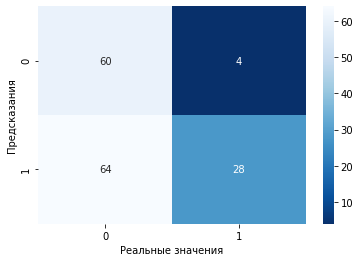

In [263]:
# матрица ошибок 

cm = confusion_matrix(y_test,y_pred_threshold)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.xlabel('Реальные значения')
plt.ylabel('Предсказания')
plt.show()

Пусть пострадала accuracy, но количество ошибок первого рода уменьшилось с 39 до 4: почти в 10 раз. Recall упала с 0.664 до 0.304, мы пропускаем больше случаев, когда молоко действительно хорошее, но классифицируем их как плохое. И все же, это не так критично, как купить корову с невкусным молоком. А precision увеличилась с 0.837 до 0.875, то есть если модель думает, что молоко хорошее, теперь это действительно будет так с немного большей вероятностью.

## Итоговая модель

In [264]:
cow_buy_milk = cow_buy.copy(deep=True)

In [265]:
cow_buy_milk.columns

Index(['порода', 'тип_пастбища', 'порода_папы_быка', 'имя_папы_быка',
       'текущая_жирность', 'текущий_белок', 'возраст', 'предсказанный_удой'],
      dtype='object')

In [266]:
cow_buy_milk['эке'] = values_extended['эке']
cow_buy_milk['эке_квадрат'] = values_extended['эке'] ** 2
cow_buy_milk['сырой_протеин'] = values_extended['сырой_протеин']
cow_buy_milk['спо'] = values_extended['спо']

spo_boundary = 0.92
cow_buy_milk['спо_бинар'] = (cow_buy_milk['спо'] > spo_boundary).astype(int)

cow_buy_milk.rename(columns={'текущая_жирность': 'жирность', 'текущий_белок': 'белок'}, inplace=True)
cow_buy_milk = cow_buy_milk.drop(['эке', 'спо', 'имя_папы_быка'], axis=1)

cow_buy_milk.head()

,порода,тип_пастбища,порода_папы_быка,жирность,белок,возраст,предсказанный_удой,эке_квадрат,сырой_протеин,спо_бинар
0,Вис Бик Айдиал,холмистое,Айдиал,3.58,3.076,более_2_лет,6609.253673,233.378833,2019.77191,1
1,Вис Бик Айдиал,равнинное,Соверин,3.54,3.081,менее_2_лет,6358.102672,233.378833,2019.77191,1
2,РефлешнСоверинг,равнинное,Соверин,3.59,3.074,более_2_лет,6283.593214,233.378833,2019.77191,1
3,РефлешнСоверинг,холмистое,Айдиал,3.40,3.061,более_2_лет,6599.114441,233.378833,2019.77191,1
4,РефлешнСоверинг,равнинное,Айдиал,3.64,3.074,более_2_лет,6544.619925,233.378833,2019.77191,1


In [267]:
#quantitative = ['эке_квадрат', 'сырой_протеин', 'жирность', 'белок']
#categoriсal = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст', 'спо_бинар']

X_train_scaled = scaler.fit_transform(X_train_full[quantitative])
X_test_scaled = scaler.transform(cow_buy_milk[quantitative])

# кодирование
X_train_ohe = encoder.fit_transform(X_train_full[categoriсal])
X_test_ohe = encoder.transform(cow_buy_milk[categoriсal])

encoder_col_names = encoder.get_feature_names_out()
X_train_scaled = pd.DataFrame(X_train_scaled, columns=quantitative)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=quantitative)
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_full = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test_full = pd.concat([X_test_ohe, X_test_scaled], axis=1)

clf.fit(X_train_full, y_train_full)
y_proba = clf.predict_proba(X_test_full)[:, 1]
predictions = (y_proba > optimal_threshold).astype(int)

In [268]:
cow_buy['предсказанный_вкус_молока'] = predictions
cow_buy['предсказанный_вкус_молока'] = cow_buy['предсказанный_вкус_молока'].apply(lambda x: 'вкусно' if x == 1 else 'не вкусно')
buying = cow_buy.query('предсказанный_вкус_молока == "вкусно" & предсказанный_удой >= 6000')
buying

,порода,тип_пастбища,порода_папы_быка,имя_папы_быка,текущая_жирность,текущий_белок,возраст,предсказанный_удой,предсказанный_вкус_молока
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,6400.619963,вкусно
16,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.079,более_2_лет,6334.076093,вкусно


Итого, модель нашла 2 коровы, которые с наибольшей вероятностью дадут более 6000 кг вкусного молока в год. 

# Итоговые выводы

В ходе данного исследования были созданы и оптимизированы две прогнозные модели, предназначенные для отбора коров, соответствующих критериям фермера. Первая модель была нацелена на прогнозирование годового удоя коров, а вторая — на оценку вероятности получения вкусного молока.  

- Данные трех исходных датасетов ferma_main, ferma_dad и cow_buy были проверены на дубликаты и пропуски, типы данных исправлены на правильные, предобработка проведена.  
- В ходе исследовательского анализа было установлено, что средняя корова на ферме — это зрелая особь породы Вис Бик Айдиал, производящая около 6 тысяч кг молока в год с жирностью 3.65%, а ее корм отличается стабильной питательной ценностью с содержанием сырого протеина около 1888 г. 
- Корреляционный анализ показал, что ключевое влияние на количество удоя имеют ЭКЕ, СПО (т.е. корм коровы), возраст и порода папы быка. 


- Были обучены три модели линейной регрессии, в результате выявлена лучшая с параметрами r2 = 0.841, mse_3 = 34749.4, mae_3 = 146.7, rmse_3 = 186.4. Используя ее, предсказали удой коров пастбища: 20 коров вероятнее всего смогут выдать удой больше 6000 кг в год. 
- Для прогноза вкуса молока была обучена модель классификации, минимизированы ошибки первого рода и подобран оптимальный порог. 

В итоге, фермеру рекомендовано выбрать 2 коровы, удой которых даст от 6000 кг вкусного молока:

In [269]:
buying

,порода,тип_пастбища,порода_папы_быка,имя_папы_быка,текущая_жирность,текущий_белок,возраст,предсказанный_удой,предсказанный_вкус_молока
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,6400.619963,вкусно
16,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.079,более_2_лет,6334.076093,вкусно
